# Projekt z Inżynierii Uczenia Maszynowego
Semestr letni 2020, WEiTI PW
## Autorzy
Przemysław Stawczyk

Maciej Szulik

## Zadanie

### Treść
*3. Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Lepiej by było, gdybyśmy wiedzieli, ile taka dostawa dla danego zamówienia może potrwać.*

### Zestaw danych


### Definicja zadania biznesowego
Oszacowanie czasu dostawy na podstawie informacji o zamówieniu.

Należy upewnić się, co takie przybliżenie da klientowi. Mówi on, że firmy nie radzą sobie z obciążeniem - może więc predykcja czasu dostawy dla każdej z firm pozwalałaby wybrać tę najmniej obciążoną? Trzeba go o to dopytać. Oprocz tego takie przewidywanie może być wykorzystane jako informacja dla klienta, kiedy prawdopodbnie nastąpi doręczenie. 

#### Biznesowe kryterium sukcesu
Dobre przybliżenie prognozowanego czasu dostawy, pozwalające określić dzień dostarczenia przesyłki.

### Definicja zadania modelowania
Przewidzenie czasu dostawy w godzinach. Jest to zadanie regresji.

#### Analityczne kryterium sukcesu
Dokładność przewidywanego czasu na poziomie +/- 8 godzin.

### Podsumowanie
W danych znaleziono braki. Co było szczególnie istotne, w danych `deliveries` brakowało niektórych wartości dotyczących czasu dostarczenia `delivery_timestamp` (uniemożliwia to określenie czasu dostawy) i firmy kurierskiej `delivery_company` (analiza wykazała silną korelację z czasem trwania dostawy). Oprócz tego ważnym brakiem było pole `user_id` w danych `sessions` dla akcji kupienia produktu `BUY_PRODUCT`, które uniemożliwało powiązanie danej dostawy z użytkownikiem, a co za tym idzie z adresem (a analiza wykazała silną korelację miasta  z czasem trwania dostawy). Te dane udało się jednak uzupełnić poprzez inne akcje wykonane przez użytkownika w obrębie danej sesji. 
Najbardziej relewantnymi atrybutami okazały się być miasto i firma kurierska. Do analizy wykorzystano pakiet sklearn feature selection i preprocessing (zostało zastosowane enkodowanie wartości). Po obróbce i odrzuceniach pozostało 6195 próbek, co jest dla nas akceptowalne.

## Analiza danych

In [40]:
import datetime
import json # as pandas struggled with json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import missingno as msno
from sklearn import preprocessing
%matplotlib inline

### Load files:

In [41]:
def load_file(filename):
    with open(filename, encoding="utf8") as f:
        data = f.readlines()
        data = [json.loads(line) for line in data] #convert string to dict format
        df = pd.json_normalize(data)
    return df

users = load_file(r'../data/users.jsonl')# pd.read_json(r"data/users.jsonl", typ='series', lines=True, dtype='dict')
users.head(30)

,user_id,name,city,street
0,102,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
1,103,Mateusz Kobel,Police,al. Wrocławska 10
2,104,Radosław Ratka,Mielec,pl. Nowa 89/04
3,105,Anastazja Oszust,Szczecin,ul. Częstochowska 80
4,106,Sylwia Nurek,Szczecin,al. Wiosenna 72
5,107,Aleksander Mendak,Police,ulica Powstańców Wielkopolskich 70/64
6,108,Ewa Szołtysik,Szczecin,plac Srebrna 965
7,109,Gustaw Janoszek,Warszawa,plac Morska 278
8,110,Ada Wojsa,Police,aleja Jana Pawła II 764
9,111,Ernest Witoń,Radom,ul. Sarnia 25


In [42]:
deliveries = load_file("../data/deliveries.jsonl")
deliveries.head(30)

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2020-04-13T14:36:52,2020-04-16T14:10:43.034629,360.0
1,20002,2020-04-19T16:41:11,None,620.0
2,20003,2020-03-22T23:31:21,2020-03-25T21:55:26.574877,516.0
3,20004,2020-05-06T07:08:11,2020-05-09T12:02:11.187799,516.0
4,20005,2020-03-21T12:13:21,2020-03-23T22:32:36.697450,620.0
5,20006,2020-04-19T00:51:28,2020-04-21T20:57:04.327567,360.0
6,20007,2020-02-01T07:59:24,2020-02-04T13:56:30.483167,516.0
7,20008,2020-04-14T11:19:13,2020-04-16T14:04:43.323323,620.0
8,20009,2020-05-12T02:51:26,2020-05-14T05:50:40.361184,620.0
9,20010,2020-03-11T09:09:53,None,360.0


In [43]:
sessions = load_file("../data/sessions.jsonl")
sessions.head(30)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2020-04-13T14:24:55,102.0,NaN,VIEW_PRODUCT,20,NaN
1,100001,2020-04-13T14:28:34,102.0,1046.0,VIEW_PRODUCT,20,NaN
2,100001,2020-04-13T14:33:28,102.0,1043.0,VIEW_PRODUCT,20,NaN
3,100001,2020-04-13T14:36:52,NaN,1043.0,BUY_PRODUCT,20,20001.0
4,100002,2020-04-19T16:28:16,102.0,1292.0,VIEW_PRODUCT,5,NaN
5,100002,2020-04-19T16:32:08,102.0,1286.0,VIEW_PRODUCT,5,NaN
6,100002,2020-04-19T16:36:14,102.0,1287.0,VIEW_PRODUCT,5,NaN
7,100002,2020-04-19T16:41:11,102.0,1287.0,BUY_PRODUCT,5,20002.0
8,100003,2020-03-22T23:23:29,102.0,1005.0,VIEW_PRODUCT,15,NaN
9,100003,2020-03-22T23:28:29,102.0,1011.0,VIEW_PRODUCT,15,NaN


In [44]:
products = load_file("../data/products.jsonl")
products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


### Analiza dostarczonych plików

In [45]:
# helper functions

def generate_sparsity_matrix(dataframe):
    missing_df = dataframe.columns[dataframe.isnull().any()].tolist()
    msno.matrix(dataframe[missing_df], figsize=(20, 5))

def clean_nan_rows(dataframe, print_stats = False):
    clean_df = dataframe.dropna(axis=0, how='any')
    if print_stats:
        print('Original Length=', len(dataframe), '\tCleaned Length=', len(clean_df), '\tMissing Data=', len(dataframe) - len(clean_df))
    return clean_df

def print_null_stats(dataframe):
    total_rows = dataframe.shape[0]
    null_values = dataframe.isnull().sum(axis = 0)

    print("Total rows: ", total_rows)
    print("\nNull values per culumn:")
    print(null_values)

#### Users

In [46]:
print_null_stats(users)

Total rows:  200

Null values per culumn:
user_id    0
name       0
city       0
street     0
dtype: int64


Dane `users` przechowują informacje o id użytkownika, imieniu i nazwisku i adresie. Nie posiadają żadnych brakujących wartości.

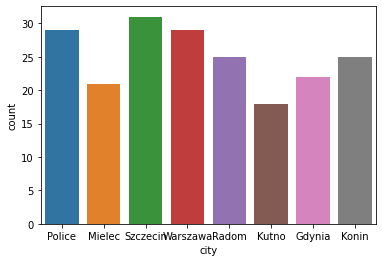

In [47]:
sn.countplot(x="city", data=users)

#### Products

In [48]:
print_null_stats(products)

negative_prices_count = products[products["price"] < 0].shape[0]

print("\nNegative prices count: ", negative_prices_count)

Total rows:  319

Null values per culumn:
product_id       0
product_name     0
category_path    0
price            0
dtype: int64

Negative prices count:  13


Dane `products` przechowują informacje o id produktu, jego nazwie, kategorii i cenie. Nie posiadają żadnych brakujących wartości. Występuje 15 przypadków, kiedy cena jest ujemna, co może budzić wątwpliwości, ale dalsza analiza tych danych w naszym przypadku nie jest konieczna, gdyż nie niosą one potrzebnych nam informacji.

#### Deliveries

Total rows:  7215

Null values per culumn:
purchase_id             0
purchase_timestamp      0
delivery_timestamp    366
delivery_company      375
dtype: int64

Brakujące czasy dostawy w deliveries:

Original Length= 7215 	Cleaned Length= 6849 	Missing Data= 366

Brakujące firmy kurierskie w deliveries:

Original Length= 7215 	Cleaned Length= 6840 	Missing Data= 375

Brakujące dane w deliveries:


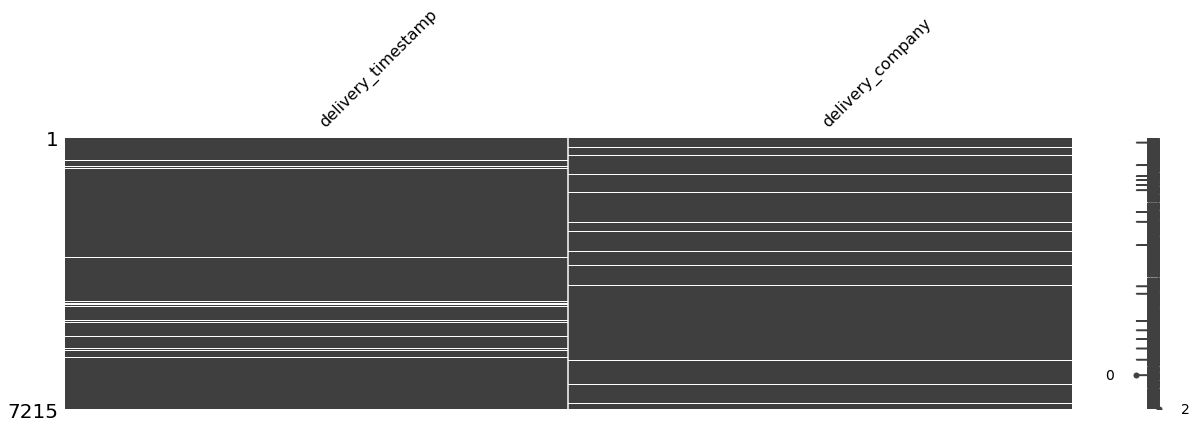

In [49]:
print_null_stats(deliveries)

print("\nBrakujące czasy dostawy w deliveries:\n")
clean_nan_rows(dataframe=deliveries['delivery_timestamp'], print_stats=True)

print("\nBrakujące firmy kurierskie w deliveries:\n")
clean_nan_rows(dataframe=deliveries['delivery_company'], print_stats=True)

print("\nBrakujące dane w deliveries:")
generate_sparsity_matrix(deliveries)

Dane `deliveries` przechowują informacje o id zakupu (powiązane z `purchase_id` w `sessions`), czasie złożenia zamowienia, czasie dostawy i firmie kurierskiej, która realizowała przesyłkę. Są to dla nas dane szczególnie istotne. Uwagę zwracają brakujące czasy dostawy (`delivery_timestamp`) dla 382 rekordów i brak identyfikatora firmy kurierskiej (`delivery_company`) dla 362, co może być dla nas problemem.

##### Analiza firm kurierskich

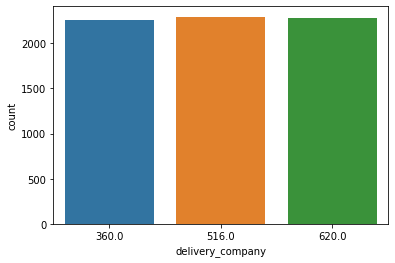

In [50]:
deliveries["delivery_company"].value_counts()
sn.countplot(x="delivery_company", data=deliveries)

Przesyłki obsługują 3 firmy kurierskie, realizując zbliżoną liczbę zamówień.

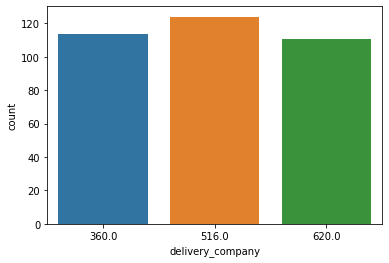

In [51]:
a = deliveries[deliveries["delivery_timestamp"].isnull()] 
sn.countplot(x="delivery_company", data=a)

Rozkład braków w `delivery_timestamp` jest zbliżony dla każdej z firm.

#### Dodatkowe analizy

In [52]:
deliveries[deliveries["purchase_timestamp"] > deliveries["delivery_timestamp"]].shape[0]

36

Nie występują anomalie, kiedy zamówienie wystąpiło później niż czas dostawy.

### Sessions

In [53]:
print_null_stats(sessions)

Total rows:  39374

Null values per culumn:
session_id              0
timestamp               0
user_id              2019
product_id           1933
event_type              0
offered_discount        0
purchase_id         32159
dtype: int64


Dane `sessions` przechowują informacje o zarejestrowanych zdarzeniach związanych z produktami, a dokładniej są to: id sesji, czas jej utworzenia, id użytkownika powiązane z sesją, id produktu, proponowana promocja na produkt, typ zdarzenia (produkt kupiony, produkt zobaczony) i powiązane id zakupu.

Interesują nas zdarzenia dotyczące kupionych produktów, bo tylko takie są dostarczane.

Te dane są dla nas kluczowe, ponieważ pozwalają powiązać dostawę (poprzez wartość `purchase_id`) z użytkownikiem (poprzez wartość `user_id`), a co za tym idzie z adresem.

Należy zatem sprawdzić, czy takie złączenie jest zawsze możliwe.

##### Analiza kupionych produktów

Upewnijmy się, że zdarzeniu `BUY_PRODUCT` zawsze odpowiada jakieś `purchase_id`.

In [54]:
sessions[(sessions["event_type"] == "BUY_PRODUCT") & (sessions["purchase_id"].isnull())].shape[0]

0

Wyselekcjonujmy z `sessions` tylko interesujące nas zdarzenia (dotyczące zdarzenia `BUY_PRODUCT`) i sprawdźmy braki danych.

Brakujące user_id w sessions dla zdarzenia BUY_PRODUCT

Original Length= 7215 	Cleaned Length= 6848 	Missing Data= 367

Brakujące dane w sessions dla operacji BUY_PRODUCT:


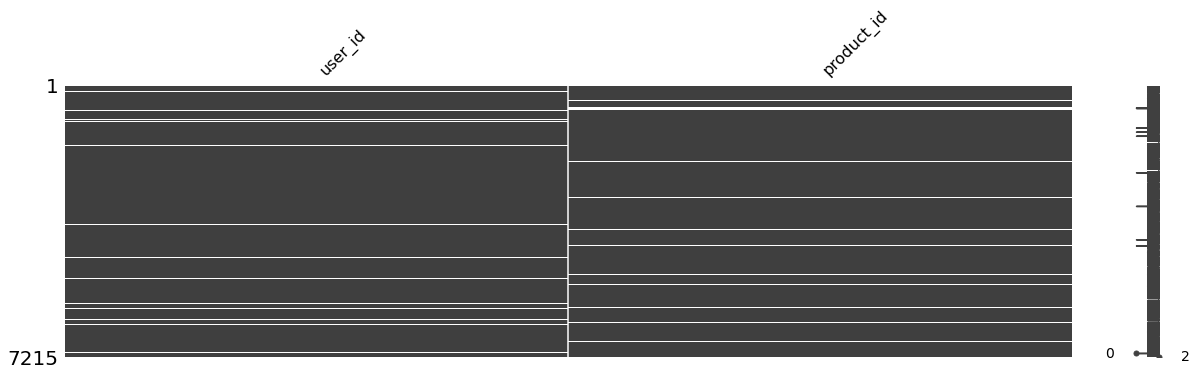

In [55]:
buy_sessions = sessions[sessions.event_type == 'BUY_PRODUCT']

print("Brakujące user_id w sessions dla zdarzenia BUY_PRODUCT\n")
clean_nan_rows(dataframe=buy_sessions['user_id'], print_stats=True)

print("\nBrakujące dane w sessions dla operacji BUY_PRODUCT:")
generate_sparsity_matrix(buy_sessions)

Jak widać nie wszystkie sesje zakończone zakupem posiadają id użytkownika, co mogłoby być przydatne do ustalenia adresu dostawy.

Taki brak da się jednak uzupełnić, jeśli dla danej sesji istnieje inna akcja, w której id użytkownika jest znane.

**Przykład:**

```json
{"session_id": 100007, "timestamp": "2020-02-02T02:03:15", "user_id": 102, "product_id": 1045, "event_type": "VIEW_PRODUCT", "offered_discount": 20, "purchase_id": null}


{"session_id": 100007, "timestamp": "2020-02-02T02:07:04", "user_id": null, "product_id": 1045, "event_type": "BUY_PRODUCT", "offered_discount": 20, "purchase_id": 20006}
```

Chociaż dla zakupu o id `20006` nie jest zdefiniowane `user_id`, to z całej sesji o id `100007` możemy to wywnioskować i uzupełnić brak ustawiając `user_id` na `102`.


Jeśli to możliwe, należy takie dane uzupełnić.

### Transformacje

Dokonajmy potrzebnych tranformacji na danych.

#### Podział na kategorię główną i podkategorię

In [56]:
category_path_arr = products['category_path'].str.split(';', 2)
category_arr = []
subcategory_arr = []
for path in category_path_arr:
    if type(path) == float:
        category_arr.append(path)
        subcategory_arr.append(path)
    else:
        category_arr.append(path[0])
        subcategory_arr.append(path[1])

products['category'] = category_arr
products['subcategory'] = subcategory_arr

products

,product_id,product_name,category_path,price,category,subcategory
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,Telefony i akcesoria,Telefony stacjonarne
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50,Komputery,Drukarki i skanery
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00,Komputery,Drukarki i skanery
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,Gry i konsole,Gry na konsole
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,Gry i konsole,Gry na konsole
...,...,...,...,...,...,...
314,1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,54.99,Telefony i akcesoria,Akcesoria telefoniczne
315,1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,249.00,Telefony i akcesoria,Akcesoria telefoniczne
316,1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1303.96,Telefony i akcesoria,Akcesoria telefoniczne
317,1318,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,553.00,Sprzęt RTV,Audio


#### Wypelnienie braków `user_id` w `sessions`

In [57]:
session_user_map=sessions[sessions["user_id"].notna()].set_index('session_id')['user_id'].to_dict()

for i, row in sessions.iterrows():
    if np.isnan(row["user_id"]) and row["session_id"] in session_user_map:
            sessions.at[i,'user_id'] = session_user_map[row["session_id"]]
            
buy_sessions = sessions[sessions.event_type == 'BUY_PRODUCT']

clean_nan_rows(dataframe=buy_sessions['user_id'], print_stats=True)

buy_sessions

Original Length= 7215 	Cleaned Length= 7205 	Missing Data= 10


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
3,100001,2020-04-13T14:36:52,102.0,1043.0,BUY_PRODUCT,20,20001.0
7,100002,2020-04-19T16:41:11,102.0,1287.0,BUY_PRODUCT,5,20002.0
11,100003,2020-03-22T23:31:21,102.0,1009.0,BUY_PRODUCT,15,20003.0
16,100004,2020-05-06T07:08:11,102.0,1081.0,BUY_PRODUCT,0,20004.0
28,100006,2020-03-21T12:13:21,102.0,1318.0,BUY_PRODUCT,0,20005.0
...,...,...,...,...,...,...,...
39352,110355,2020-05-12T21:36:39,301.0,1276.0,BUY_PRODUCT,0,27211.0
39363,110356,2020-03-04T18:16:46,301.0,1006.0,BUY_PRODUCT,0,27212.0
39365,110357,2020-01-16T05:18:31,301.0,1017.0,BUY_PRODUCT,0,27213.0
39367,110358,2020-05-09T12:32:59,301.0,NaN,BUY_PRODUCT,0,27214.0


Dzięki takiej operacji, liczba wierszy z brakiem `user_id` zmniejszyła się z 368 do 8. Z pozostałymi nie da się nic już zrobić, więc je usuniemy.

In [58]:
buy_sessions = buy_sessions[buy_sessions["user_id"].notna()]
buy_sessions

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
3,100001,2020-04-13T14:36:52,102.0,1043.0,BUY_PRODUCT,20,20001.0
7,100002,2020-04-19T16:41:11,102.0,1287.0,BUY_PRODUCT,5,20002.0
11,100003,2020-03-22T23:31:21,102.0,1009.0,BUY_PRODUCT,15,20003.0
16,100004,2020-05-06T07:08:11,102.0,1081.0,BUY_PRODUCT,0,20004.0
28,100006,2020-03-21T12:13:21,102.0,1318.0,BUY_PRODUCT,0,20005.0
...,...,...,...,...,...,...,...
39352,110355,2020-05-12T21:36:39,301.0,1276.0,BUY_PRODUCT,0,27211.0
39363,110356,2020-03-04T18:16:46,301.0,1006.0,BUY_PRODUCT,0,27212.0
39365,110357,2020-01-16T05:18:31,301.0,1017.0,BUY_PRODUCT,0,27213.0
39367,110358,2020-05-09T12:32:59,301.0,NaN,BUY_PRODUCT,0,27214.0


Pozbądźmy się pozostałych pustych `user_id`, ponieważ nie da się z nimi już nic zrobić. Do dalszej obróbki potrzebe będą wyłącznie `buy_sessions`, więc nadpiszmy dataframe.

In [59]:
buy_sessions = buy_sessions[buy_sessions["user_id"].notnull()]
sessions_with_nulls = sessions
sessions = buy_sessions

#### Usunięcie braków w `deliveries`
W przeciwieństwie do problemu z `user_id` braki w tych danych trudno uzupełnić, więc uszkodzone dane zostaną usunięte.

In [60]:
deliveries_with_nulls = deliveries
deliveries = deliveries.dropna()

#### Złączenie tabel

In [61]:
# inner join sessions and deliveries
merged_data = pd.merge(left=sessions, right=deliveries, left_on='purchase_id', right_on='purchase_id')

# left join users
merged_data = pd.merge(left=merged_data, right=users, how='left', left_on='user_id', right_on='user_id')

# left join products
merged_data = pd.merge(left=merged_data, right=products, how='left', left_on='product_id', right_on='product_id')

merged_data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,name,city,street,product_name,category_path,price,category,subcategory
0,100001,2020-04-13T14:36:52,102.0,1043.0,BUY_PRODUCT,20,20001.0,2020-04-13T14:36:52,2020-04-16T14:10:43.034629,360.0,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Fight Night Champion (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,109.00,Gry i konsole,Gry na konsole
1,100003,2020-03-22T23:31:21,102.0,1009.0,BUY_PRODUCT,15,20003.0,2020-03-22T23:31:21,2020-03-25T21:55:26.574877,516.0,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69.00,Gry i konsole,Gry na konsole
2,100004,2020-05-06T07:08:11,102.0,1081.0,BUY_PRODUCT,0,20004.0,2020-05-06T07:08:11,2020-05-09T12:02:11.187799,516.0,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,OKI B840dn,Komputery;Drukarki i skanery;Biurowe urządzeni...,5259.00,Komputery,Drukarki i skanery
3,100006,2020-03-21T12:13:21,102.0,1318.0,BUY_PRODUCT,0,20005.0,2020-03-21T12:13:21,2020-03-23T22:32:36.697450,620.0,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,553.00,Sprzęt RTV,Audio
4,100009,2020-04-19T00:51:28,102.0,1318.0,BUY_PRODUCT,0,20006.0,2020-04-19T00:51:28,2020-04-21T20:57:04.327567,360.0,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,553.00,Sprzęt RTV,Audio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6479,110355,2020-05-12T21:36:39,301.0,1276.0,BUY_PRODUCT,0,27211.0,2020-05-12T21:36:39,2020-05-14T19:35:29.399789,516.0,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97,Komputery,Tablety i akcesoria
6480,110356,2020-03-04T18:16:46,301.0,1006.0,BUY_PRODUCT,0,27212.0,2020-03-04T18:16:46,2020-03-06T16:05:57.868149,516.0,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90,Gry i konsole,Gry na konsole
6481,110357,2020-01-16T05:18:31,301.0,1017.0,BUY_PRODUCT,0,27213.0,2020-01-16T05:18:31,2020-01-18T12:12:34.191550,516.0,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,LCD Dell U2412M,Komputery;Monitory;Monitory LCD,399.00,Komputery,Monitory
6482,110358,2020-05-09T12:32:59,301.0,NaN,BUY_PRODUCT,0,27214.0,2020-05-09T12:32:59,2020-05-11T05:38:07.845365,360.0,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,NaN,NaN,NaN,NaN,NaN


#### Odrzucenie niepotrzebnych kolumn

Odrzućmy część kolumn, które zdają się być zbędne:
- id sesji - kolumna identyfikacyjna
- id zakupu - kolumna identyfikacyjna
- id użytkownika - kolumna identyfikacyjna
- id produktu - kolumna identyfikacyjna, zbyt rozdrobniona
- product name - nazwa produktu jest zbyt rozdrobniona *[zbyt wiele różnych wartości]*, kategoria do 2 poziomu wydaje się być dobrym zastępstwem
- typ zdarzenia - rozpatrujemy wyłącznie zakup
- oferowana obniżka - nie ma znaczenia na dostawę *(opcjonalnie jako wart binarna)*
- imie i nazwisko użytkownika - konkretny użytkownik nie powinien być powiązany z dostawą
- timestamp sesji - interesuje nas czas dostawy od czasu *zakupu* do *dostarczenia*
- ulica - zbyt rozdrobniona kolumna *[zbyt wiele różnych wartości]*


In [62]:
columns = ['session_id', 'purchase_id','user_id', 'product_id', 'event_type',
           'offered_discount', 'name', 'timestamp', 'product_name', 'street']
for col in columns:
    merged_data = merged_data.drop(col, axis=1)

merged_data


,purchase_timestamp,delivery_timestamp,delivery_company,city,category_path,price,category,subcategory
0,2020-04-13T14:36:52,2020-04-16T14:10:43.034629,360.0,Police,Gry i konsole;Gry na konsole;Gry PlayStation3,109.00,Gry i konsole,Gry na konsole
1,2020-03-22T23:31:21,2020-03-25T21:55:26.574877,516.0,Police,Gry i konsole;Gry na konsole;Gry Xbox 360,69.00,Gry i konsole,Gry na konsole
2,2020-05-06T07:08:11,2020-05-09T12:02:11.187799,516.0,Police,Komputery;Drukarki i skanery;Biurowe urządzeni...,5259.00,Komputery,Drukarki i skanery
3,2020-03-21T12:13:21,2020-03-23T22:32:36.697450,620.0,Police,Sprzęt RTV;Audio;Słuchawki,553.00,Sprzęt RTV,Audio
4,2020-04-19T00:51:28,2020-04-21T20:57:04.327567,360.0,Police,Sprzęt RTV;Audio;Słuchawki,553.00,Sprzęt RTV,Audio
...,...,...,...,...,...,...,...,...
6479,2020-05-12T21:36:39,2020-05-14T19:35:29.399789,516.0,Warszawa,Komputery;Tablety i akcesoria;Tablety,1816.97,Komputery,Tablety i akcesoria
6480,2020-03-04T18:16:46,2020-03-06T16:05:57.868149,516.0,Warszawa,Gry i konsole;Gry na konsole;Gry Xbox 360,59.90,Gry i konsole,Gry na konsole
6481,2020-01-16T05:18:31,2020-01-18T12:12:34.191550,516.0,Warszawa,Komputery;Monitory;Monitory LCD,399.00,Komputery,Monitory
6482,2020-05-09T12:32:59,2020-05-11T05:38:07.845365,360.0,Warszawa,NaN,NaN,NaN,NaN


#### Kolumny wyliczane.
Przydatny będzie właściwy czas dostawy, wyrażany np. w godzinach.

In [63]:
merged_data['delivery_timestamp'] = \
    pd.to_datetime(merged_data.delivery_timestamp)
merged_data['purchase_timestamp'] = \
    pd.to_datetime(merged_data.purchase_timestamp)
merged_data['delivery_total_time'] = \
    merged_data['delivery_timestamp'] - merged_data['purchase_timestamp']

merged_data['delivery_total_time_hours'] = \
    merged_data['delivery_total_time'].dt.total_seconds()/3600

merged_data['purchase_hour'] = \
    merged_data['purchase_timestamp'].dt.hour + merged_data['purchase_timestamp'].dt.minute / 60

merged_data[['delivery_total_time','delivery_total_time_hours']]

,delivery_total_time,delivery_total_time_hours
0,2 days 23:33:51.034629,71.564176
1,2 days 22:24:05.574877,70.401549
2,3 days 04:54:00.187799,76.900052
3,2 days 10:19:15.697450,58.321027
4,2 days 20:05:36.327567,68.093424
...,...,...
6479,1 days 21:58:50.399789,45.980667
6480,1 days 21:49:11.868149,45.819963
6481,2 days 06:54:03.191550,54.900887
6482,1 days 17:05:08.845365,41.085790


### Dalsza analiza

##### Rozkład czasu dostawy w godzinach w zależności od firmy kurierskiej

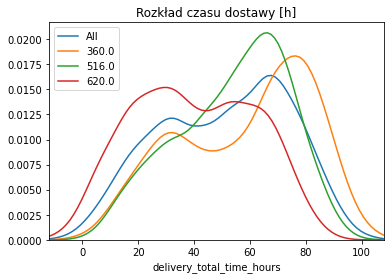

In [64]:
max_h = merged_data["delivery_total_time_hours"].max()
min_h = merged_data["delivery_total_time_hours"].min()

plt.title("Rozkład czasu dostawy [h]")

sn.distplot(merged_data["delivery_total_time_hours"], hist=False, label="All").set(xlim=(min_h, max_h))

for company in [x for x in merged_data["delivery_company"].unique() if ~np.isnan(x)]:
    sn.distplot(merged_data[merged_data["delivery_company"] == company]["delivery_total_time_hours"],hist=False, label=str(company)).set(xlim=(min_h, max_h))

##### Miasto a firma kurierska

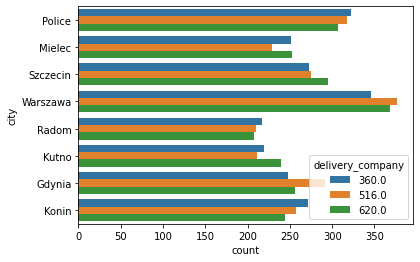

In [65]:
sn.countplot(y="city", hue="delivery_company", data=merged_data)

##### Miasto a firma kurierska dla brakujących czasów dostawy

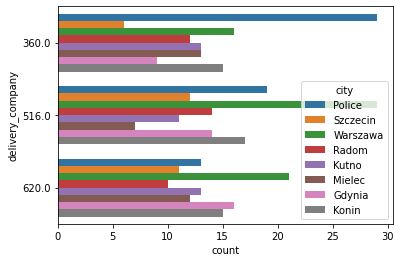

In [66]:
# inner join sessions and deliveries
merge_data_nulls = pd.merge(left=sessions_with_nulls, right=deliveries_with_nulls, left_on='purchase_id', right_on='purchase_id')
# left join users
merge_data_nulls = pd.merge(left=merge_data_nulls, right=users, how='left', left_on='user_id', right_on='user_id')
# left join products
merge_data_nulls = pd.merge(left=merge_data_nulls, right=products, how='left', left_on='product_id', right_on='product_id')

merge_data_nulls = merge_data_nulls[merge_data_nulls["delivery_timestamp"].isnull()]

sn.countplot(y="delivery_company", hue="city", data=merge_data_nulls)

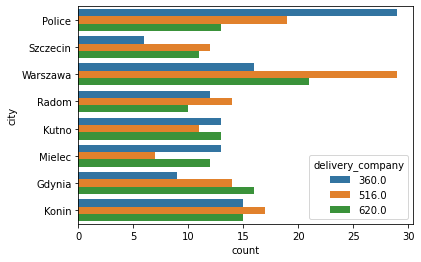

In [67]:
sn.countplot(y="city", hue="delivery_company", data=merge_data_nulls)

### Czas w Mieście

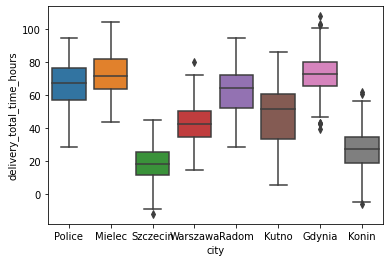

In [68]:
sn.boxplot(x=merged_data['city'], y=merged_data['delivery_total_time_hours'])

### Czas Dostawy Firmy Kurierskiej

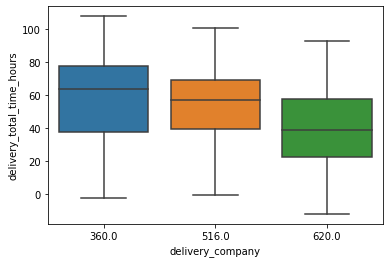

In [69]:
sn.boxplot(x=merged_data['delivery_company'], y=merged_data['delivery_total_time_hours'])

### Firma Kurierska w Mieście

In [70]:
company_in_city = pd.DataFrame(merged_data)
company_in_city['city-company'] = company_in_city['city']+'-'+company_in_city['delivery_company'].astype(str)

company_in_city

,purchase_timestamp,delivery_timestamp,delivery_company,city,category_path,price,category,subcategory,delivery_total_time,delivery_total_time_hours,purchase_hour,city-company
0,2020-04-13 14:36:52,2020-04-16 14:10:43.034629,360.0,Police,Gry i konsole;Gry na konsole;Gry PlayStation3,109.00,Gry i konsole,Gry na konsole,2 days 23:33:51.034629,71.564176,14.600000,Police-360.0
1,2020-03-22 23:31:21,2020-03-25 21:55:26.574877,516.0,Police,Gry i konsole;Gry na konsole;Gry Xbox 360,69.00,Gry i konsole,Gry na konsole,2 days 22:24:05.574877,70.401549,23.516667,Police-516.0
2,2020-05-06 07:08:11,2020-05-09 12:02:11.187799,516.0,Police,Komputery;Drukarki i skanery;Biurowe urządzeni...,5259.00,Komputery,Drukarki i skanery,3 days 04:54:00.187799,76.900052,7.133333,Police-516.0
3,2020-03-21 12:13:21,2020-03-23 22:32:36.697450,620.0,Police,Sprzęt RTV;Audio;Słuchawki,553.00,Sprzęt RTV,Audio,2 days 10:19:15.697450,58.321027,12.216667,Police-620.0
4,2020-04-19 00:51:28,2020-04-21 20:57:04.327567,360.0,Police,Sprzęt RTV;Audio;Słuchawki,553.00,Sprzęt RTV,Audio,2 days 20:05:36.327567,68.093424,0.850000,Police-360.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6479,2020-05-12 21:36:39,2020-05-14 19:35:29.399789,516.0,Warszawa,Komputery;Tablety i akcesoria;Tablety,1816.97,Komputery,Tablety i akcesoria,1 days 21:58:50.399789,45.980667,21.600000,Warszawa-516.0
6480,2020-03-04 18:16:46,2020-03-06 16:05:57.868149,516.0,Warszawa,Gry i konsole;Gry na konsole;Gry Xbox 360,59.90,Gry i konsole,Gry na konsole,1 days 21:49:11.868149,45.819963,18.266667,Warszawa-516.0
6481,2020-01-16 05:18:31,2020-01-18 12:12:34.191550,516.0,Warszawa,Komputery;Monitory;Monitory LCD,399.00,Komputery,Monitory,2 days 06:54:03.191550,54.900887,5.300000,Warszawa-516.0
6482,2020-05-09 12:32:59,2020-05-11 05:38:07.845365,360.0,Warszawa,NaN,NaN,NaN,NaN,1 days 17:05:08.845365,41.085790,12.533333,Warszawa-360.0


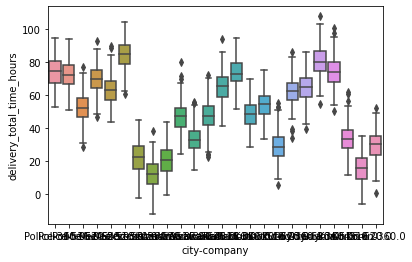

In [71]:
sn.boxplot(x=company_in_city['city-company'], y=company_in_city['delivery_total_time_hours'])

### Analiza związku z celem
- ciąg dalszy na końcu

In [72]:
from sklearn.feature_selection import mutual_info_regression, f_regression

test_data = merged_data
columns = ['purchase_timestamp', 'delivery_timestamp', 'category_path', 'city-company']
for col in columns:
    test_data = test_data.drop(col, axis=1)

target = test_data['delivery_total_time_hours']
data = test_data.drop(['delivery_total_time','delivery_total_time_hours'], axis=1)


# fill missing and code labels
data['category'] = data['category'].fillna('missing') 
data['subcategory'] = data['subcategory'].fillna('missing') 
data['city'] = data['city'].fillna('missing') 
data = data.fillna(0)
target = target.fillna(0)

le_cat = preprocessing.LabelEncoder()
le_cat.fit(np.unique(np.array(data['category'])))
data['category'] = le_cat.transform(data['category'])

le_subcat = preprocessing.LabelEncoder()
le_subcat.fit(np.unique(np.array(data['subcategory'])))
data['subcategory'] = le_subcat.transform(data['subcategory'])

le_city = preprocessing.LabelEncoder()
le_city.fit(np.unique(np.array(data['city'])))
data['city'] = le_city.transform(data['city'])

mi = mutual_info_regression(data, target)

ft = f_regression(data, target)

feature_selection = pd.DataFrame.from_records([mi, ft[0], ft[1]], columns=data.columns.to_numpy(), index=['Mutual info','F test','F p-val'])
feature_selection

,delivery_company,city,price,category,subcategory,purchase_hour
Mutual info,9.248312e-02,6.169044e-01,0.000000,0.000000,0.009856,0.000000
F test,6.813548e+02,5.583503e+02,1.244774,0.072265,0.687343,3.612697
F p-val,6.649761e-143,1.744085e-118,0.264594,0.788075,0.407100,0.057384


### Eksperymenty z modelami (dalszy etap)
- no imputation, no parameter scaling

In [73]:
clean_data = merged_data

# information form these columns has been transferred to delivery_total_time and category + subcategory
columns = ['purchase_timestamp', 'delivery_timestamp', 'category_path', 'city-company']
for col in columns:
    clean_data = clean_data.drop(col, axis=1)

clean_data = clean_data.dropna(axis=0, how='any')

target = clean_data['delivery_total_time_hours']
data = clean_data.drop(['delivery_total_time','delivery_total_time_hours'], axis=1)

# code labels
le_cat = preprocessing.LabelEncoder()
le_cat.fit(np.unique(np.array(data['category'])))
data['category'] = le_cat.transform(data['category'])

le_subcat = preprocessing.LabelEncoder()
le_subcat.fit(np.unique(np.array(data['subcategory'])))
data['subcategory'] = le_subcat.transform(data['subcategory'])

le_city = preprocessing.LabelEncoder()
le_city.fit(np.unique(np.array(data['city'])))
data['city'] = le_city.transform(data['city'])

In [74]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

def train_tree_reg(data, target, k_model, k_fold_ratio=5, rand=3228):
    k_fold = KFold(n_splits=k_fold_ratio, random_state=rand, shuffle=True)
    data_arr = np.array(data)
    target_arr = np.array(target)

    max_errors = []
    mean_absolute_errors = []
    mean_squared_errors = []

    for train_index, test_index in k_fold.split(data_arr):
        train_X, valid_X = data_arr[train_index], data_arr[test_index]
        train_y, valid_y = target_arr[train_index], target_arr[test_index]

        k_model = k_model.fit(train_X, train_y)

        k_predict = k_model.predict(valid_X)

        # code for calculating metrics
        max_errors.append(max_error(valid_y, k_predict))
        mean_absolute_errors.append(mean_absolute_error(valid_y, k_predict))
        mean_squared_errors.append(mean_squared_error(valid_y, k_predict))

    # train resulting model
    k_model.fit(data, target)

    return k_model, \
           np.max(max_errors), \
           np.average(mean_absolute_errors), \
           np.average(mean_squared_errors)

# test data
x_train, x_test, y_train, y_test = \
    train_test_split(data, target, test_size=0.2, random_state=0)

#### KNeighborsRegressor

In [75]:
data_knn_reg = []

for weight in ['uniform', 'distance']:
    for i in [2, 3, 4, 6, 8, 12]:
        line = []

        k_model = KNeighborsRegressor(n_neighbors=i, weights=weight)

        line.append(i), line.append(weight)

        model, err, avg, avg_sqr = train_tree_reg(x_train, y_train, k_model, 10)

        line.append(err),line.append(avg),line.append(avg_sqr)

        test_predictions = model.predict(x_test)

        err = max_error(y_test, test_predictions)
        avg = mean_absolute_error(y_test, test_predictions)
        avg_sqr = mean_squared_error(y_test, test_predictions)

        line.append(err),line.append(avg),line.append(avg_sqr)
        
        data_knn_reg.append(line)

knn_reg = pd.DataFrame.from_records(data_knn_reg, columns=['k', 'weights', 'learn max error', 'learn avg error', 'learn avg sqr error', 'test max error', 'test avg error', 'test avg sqr error'])

knn_reg

,k,weights,learn max error,learn avg error,learn avg sqr error,test max error,test avg error,test avg sqr error
0,2,uniform,89.377805,18.329316,544.262983,74.866440,18.142611,537.677560
1,3,uniform,83.160835,18.028630,510.857341,65.061868,17.896562,507.162595
2,4,uniform,77.934837,18.078256,501.048879,66.210620,17.919766,494.459079
3,6,uniform,81.274344,18.094406,488.494523,60.582422,18.034397,489.933559
4,8,uniform,73.749402,18.187644,484.856713,61.750407,18.231814,489.640638
5,12,uniform,66.211378,18.348543,485.680540,59.680669,18.581579,494.372708
6,2,distance,89.072355,17.783653,528.244336,78.812729,17.235619,505.829442
7,3,distance,84.961981,17.258784,486.567350,70.622404,16.772979,468.585801
8,4,distance,79.226998,17.063330,467.458246,65.992534,16.610575,449.425761
9,6,distance,81.910305,16.879194,446.390495,58.205813,16.462363,433.287782


In [76]:
data_tree_reg = []

tree_features_importances = []
index_features_importances = []

for i in range(1,9):
    line = []
    k_model = DecisionTreeRegressor(max_depth=i)

    model, err, avg, avg_sqr = train_tree_reg(x_train, y_train, k_model, 10)

    line.append(i),line.append(err),line.append(avg),line.append(avg_sqr)

    test_predictions = model.predict(x_test)

    err = max_error(y_test, test_predictions)
    avg = mean_absolute_error(y_test, test_predictions)
    avg_sqr = mean_squared_error(y_test, test_predictions)

    line.append(err),line.append(avg),line.append(avg_sqr)

    data_tree_reg.append(line)
    
    tree_features_importances.append(model.feature_importances_)
    index_features_importances.append("tree max_depth = " + str(i))

tree_reg = pd.DataFrame.from_records(data_tree_reg, columns=['depth', 'learn max error', 'learn avg error', 'learn avg sqr error', 'test max error', 'test avg error', 'test avg sqr error'])

tree_reg

,depth,learn max error,learn avg error,learn avg sqr error,test max error,test avg error,test avg sqr error
0,1,64.130303,16.118302,394.194785,60.171814,16.233782,392.809557
1,2,59.128460,13.570475,290.739776,54.015793,13.667941,294.390905
2,3,50.019484,9.891110,158.604733,40.002179,9.391759,143.469639
3,4,43.311309,8.431376,112.477454,36.273635,8.102681,106.931918
4,5,31.041709,7.114724,79.297570,27.298341,6.894040,73.353279
5,6,32.440950,7.101252,78.589082,32.940904,6.908529,74.466808
6,7,33.520603,7.230359,81.815431,35.012713,7.017299,77.052658
7,8,35.967480,7.472270,87.452752,40.728627,7.209725,82.597476


### Analiza związku z celem c.d.

In [77]:
feature_selection = pd.concat([feature_selection, pd.DataFrame.from_records(tree_features_importances, index=index_features_importances, columns=data.columns.to_numpy())])
feature_selection


,delivery_company,city,price,category,subcategory,purchase_hour
Mutual info,9.248312e-02,6.169044e-01,0.000000,0.000000,0.009856,0.000000
F test,6.813548e+02,5.583503e+02,1.244774,0.072265,0.687343,3.612697
F p-val,6.649761e-143,1.744085e-118,0.264594,0.788075,0.407100,0.057384
tree max_depth = 1,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000
tree max_depth = 2,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000
tree max_depth = 3,7.820999e-02,9.217900e-01,0.000000,0.000000,0.000000,0.000000
tree max_depth = 4,9.349837e-02,9.055737e-01,0.000356,0.000000,0.000000,0.000572
tree max_depth = 5,1.473192e-01,8.499569e-01,0.000785,0.000000,0.000188,0.001752
tree max_depth = 6,1.493745e-01,8.437875e-01,0.002958,0.000461,0.000766,0.002653
tree max_depth = 7,1.485016e-01,8.383994e-01,0.004675,0.000728,0.001253,0.006443


Jak widać największe znaczenie mają miasta i firmy kurierskiej. Zależność z podkategorią i ceną ma o wiele mniejsze znaczenie.

In [78]:
data

,delivery_company,city,price,category,subcategory,purchase_hour
0,360.0,4,109.00,0,4,14.600000
1,516.0,4,69.00,0,4,23.516667
2,516.0,4,5259.00,1,2,7.133333
3,620.0,4,553.00,2,1,12.216667
4,360.0,4,553.00,2,1,0.850000
...,...,...,...,...,...,...
6478,360.0,7,3029.00,1,5,19.733333
6479,516.0,7,1816.97,1,7,21.600000
6480,516.0,7,59.90,0,4,18.266667
6481,516.0,7,399.00,1,5,5.300000
